# Notebook to extract hidden-states and attention heads activations from gpt2 model predictions

In [41]:
import os
import glob
import torch
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import GPT2Extractor
from sklearn.preprocessing import StandardScaler
from tokenizer import tokenize
from utils import set_seed
from numpy import linalg as la

In [42]:
def check_folder(path):
    """Create adequate folders if necessary."""
    try:
        if not os.path.isdir(path):
            check_folder(os.path.dirname(path))
            os.mkdir(path)
    except:
        pass

In [43]:
def transform(activations, path, name, run_index, n_layers_hidden=13, n_layers_attention=12, hidden_size=768):
    assert activations.values.shape[1] == (n_layers_hidden + n_layers_attention) * hidden_size
    indexes = [[index*hidden_size, (index+1)*hidden_size] for index in range(n_layers_hidden + n_layers_attention)]
    for order in [np.inf]:
        matrices = []
        for index in indexes:
            matrix = activations.values[:, index[0]:index[1]]
            with_std = True if order=='std' else False
            scaler = StandardScaler(with_mean=True, with_std=with_std)
            scaler.fit(matrix)
            matrix = scaler.transform(matrix)
            if order is not None and order != 'std':
                matrix = matrix / np.mean(la.norm(matrix, ord=order, axis=1))
            matrices.append(matrix)
        matrices = np.hstack(matrices)
        new_data = pd.DataFrame(matrices, columns=activations.columns)
        new_path = path + '_norm-' + str(order).replace('np.', '')
        check_folder(new_path)
        new_data.to_csv(os.path.join(new_path, name + '_run{}.csv'.format(run_index + 1)), index=False)


Defining variables:

In [44]:
template = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/text_english_run*.txt' # path to text input
language = 'english'

Creating iterator for each run:

In [45]:
#template = '/Users/alexpsq/Code/Parietal/data/text_english_run*.txt' # path to text input


In [46]:
paths = sorted(glob.glob(template))

In [48]:
iterator_list = [tokenize(path, language, train=False) for path in paths]

100%|██████████| 207/207 [00:00<00:00, 263177.00it/s]


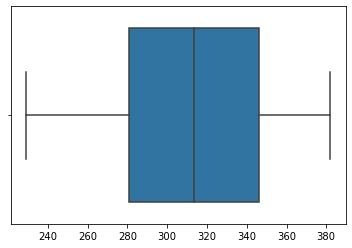

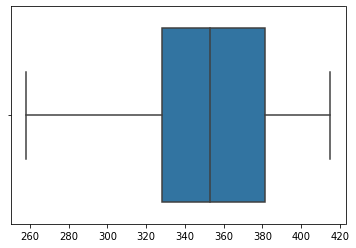

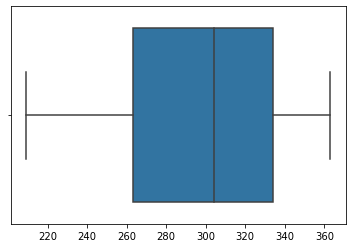

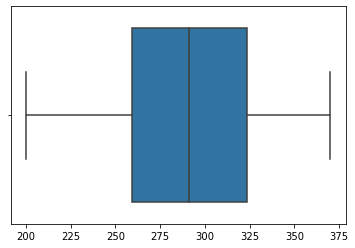

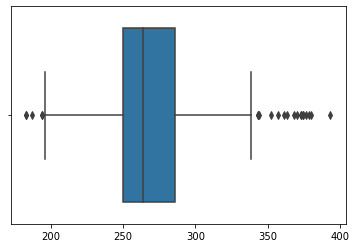

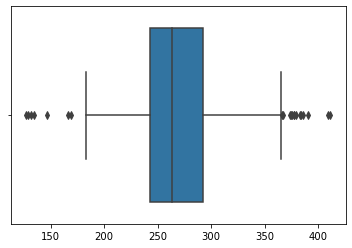

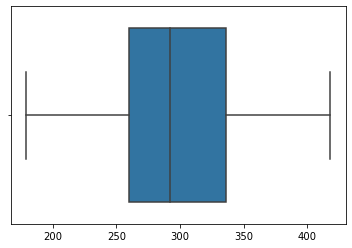

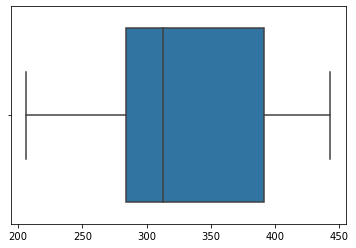

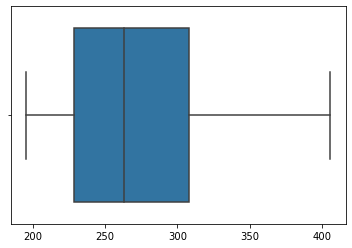


298.975676690557
292.0
295.1111111111111


In [27]:
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

lengths = []

for index in range(9):
    batches, indexes = utils.batchify_per_sentence_with_context(
                iterator_list[index], 
                1, 
                20, 
                'gpt2', 
                max_length=512)
    #lengths.append(np.array(sorted([len(item.split()) for item in batches])))
    lengths.append(np.array(sorted([len(tokenizer.tokenize(item)) for item in batches])))

    sns.boxplot(lengths[-1])
    plt.show()
    print()

print(np.mean(np.array([np.mean(item) for item in lengths])))
print(np.median(np.array([np.median(item) for item in lengths])))
print(np.mean(np.array([np.median(item) for item in lengths])))

In [51]:
pretrained_gpt2_models = ['gpt2'] * 21
names = [
    'gpt2_pre-0_1',
    'gpt2_pre-1_1',
    'gpt2_pre-2_1',
    'gpt2_pre-3_1',
    'gpt2_pre-4_1',
    'gpt2_pre-5_1',
    'gpt2_pre-6_1',
    'gpt2_pre-7_1',
    'gpt2_pre-8_1',
    'gpt2_pre-9_1',
    'gpt2_pre-10_1',
    'gpt2_pre-11_1',
    'gpt2_pre-12_1',
    'gpt2_pre-13_1',
    'gpt2_pre-14_1',
    'gpt2_pre-15_1',
    'gpt2_pre-16_1',
    'gpt2_pre-17_1',
    'gpt2_pre-18_1',
    'gpt2_pre-19_1',
    'gpt2_pre-20_1',
        ]
config_paths = [None] * 21
saving_path_folders = [
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-0_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-1_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-2_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-3_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-4_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-5_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-6_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-7_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-8_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-9_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-10_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-11_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-12_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-13_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-14_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-15_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-16_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-17_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-18_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-19_1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_pre-20_1'.format(language),
]
prediction_types = ['sentence'] * 21
number_of_sentence_list = [1] * 21
number_of_sentence_before_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]  
attention_length_before_list = [0] * 21
stop_attention_at_sent_list = [1] * 3
stop_attention_before_sent_list = [1, -1]


In [52]:
saving_path_folders

['/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_pre-0_1',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_pre-1_1',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_pre-2_1',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_pre-3_1',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_pre-4_1',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_pre-5_1',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_pre-6_1',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations

## Activation extraction

In [53]:
output_attentions = False
output_hidden_states = True

In [54]:
for index, gpt2_model in enumerate(pretrained_gpt2_models):
    extractor = GPT2Extractor(gpt2_model, 
                              language, 
                              names[index], 
                              prediction_types[index],
                              output_hidden_states=output_hidden_states, 
                              output_attentions=output_attentions,
                              attention_length_before=attention_length_before_list[index],
                              config_path=config_paths[index],
                              max_length=512, 
                              number_of_sentence=number_of_sentence_list[index], 
                              number_of_sentence_before=number_of_sentence_before_list[index],
                              stop_attention_at_sent=stop_attention_at_sent_list[index],
                              stop_attention_before_sent=stop_attention_before_sent_list[index]
                             )
    print(extractor.name, ' - Extracting activations ...')
    for run_index, iterator in tqdm(enumerate(iterator_list)):
        gc.collect()
        print("############# Run {} #############".format(run_index))
        activations  = extractor.extract_activations(iterator, language)
        hidden_states_activations = activations[0]
        attention_heads_activations = activations[1]
        #activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)
        
        transform(
            hidden_states_activations, 
            saving_path_folders[index], 
            'activations', 
            run_index=run_index,
            n_layers_hidden=13,
            n_layers_attention=0, 
            hidden_size=768)
        
        #transform(cls_activations, saving_path_folders[index], 'cls')
        #transform(sep_activations, saving_path_folders[index], 'sep')
        
        #activations.to_csv(os.path.join(saving_path_folders[index], 'activations_run{}.csv'.format(run_index + 1)), index=False)
        #cls_activations.to_csv(os.path.join(saving_path_folders[index], 'cls_run{}.csv'.format(run_index + 1)), index=False)
        #sep_activations.to_csv(os.path.join(saving_path_folders[index], 'sep_run{}.csv'.format(run_index + 1)), index=False)
        del activations
        del hidden_states_activations
        #del attention_heads_activations

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-0_1  - Extracting activations ...
############# Run 0 #############


1it [00:32, 32.38s/it]

############# Run 1 #############


2it [01:06, 33.04s/it]

############# Run 2 #############


3it [01:54, 37.40s/it]

############# Run 3 #############


4it [02:56, 44.73s/it]

############# Run 4 #############


5it [03:34, 42.76s/it]

############# Run 5 #############


6it [04:25, 45.14s/it]

############# Run 6 #############


7it [05:06, 43.96s/it]

############# Run 7 #############


8it [05:40, 40.90s/it]

############# Run 8 #############


9it [06:24, 42.73s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-1_1  - Extracting activations ...
############# Run 0 #############


1it [00:44, 44.63s/it]

############# Run 1 #############


2it [01:27, 44.17s/it]

############# Run 2 #############


3it [02:04, 41.99s/it]

############# Run 3 #############


4it [02:39, 39.78s/it]

############# Run 4 #############


5it [03:14, 38.54s/it]

############# Run 5 #############


6it [03:59, 40.22s/it]

############# Run 6 #############


7it [04:38, 40.00s/it]

############# Run 7 #############


8it [05:13, 38.47s/it]

############# Run 8 #############


9it [06:10, 41.20s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-2_1  - Extracting activations ...
############# Run 0 #############


1it [00:35, 35.77s/it]

############# Run 1 #############


2it [01:09, 35.30s/it]

############# Run 2 #############


3it [01:54, 38.14s/it]

############# Run 3 #############


4it [02:30, 37.49s/it]

############# Run 4 #############


5it [03:05, 36.57s/it]

############# Run 5 #############


6it [03:45, 37.75s/it]

############# Run 6 #############


7it [04:56, 47.79s/it]

############# Run 7 #############


8it [07:43, 83.38s/it]

############# Run 8 #############


9it [08:25, 56.12s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-3_1  - Extracting activations ...
############# Run 0 #############


1it [00:43, 43.73s/it]

############# Run 1 #############


2it [01:30, 44.76s/it]

############# Run 2 #############


3it [02:14, 44.52s/it]

############# Run 3 #############


4it [02:51, 42.17s/it]

############# Run 4 #############


5it [03:27, 40.17s/it]

############# Run 5 #############


6it [04:08, 40.62s/it]

############# Run 6 #############


7it [04:51, 41.18s/it]

############# Run 7 #############


8it [05:27, 39.81s/it]

############# Run 8 #############


9it [06:28, 43.12s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-4_1  - Extracting activations ...
############# Run 0 #############


1it [00:38, 38.60s/it]

############# Run 1 #############


2it [01:14, 37.88s/it]

############# Run 2 #############


3it [01:55, 38.61s/it]

############# Run 3 #############


4it [02:33, 38.59s/it]

############# Run 4 #############


5it [03:10, 38.15s/it]

############# Run 5 #############


6it [03:56, 40.31s/it]

############# Run 6 #############


7it [05:00, 47.45s/it]

############# Run 7 #############


8it [05:44, 46.53s/it]

############# Run 8 #############


9it [06:29, 43.32s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-5_1  - Extracting activations ...
############# Run 0 #############


1it [00:34, 34.37s/it]

############# Run 1 #############


2it [01:12, 35.49s/it]

############# Run 2 #############


3it [01:55, 37.69s/it]

############# Run 3 #############


4it [02:47, 42.04s/it]

############# Run 4 #############


5it [03:42, 45.94s/it]

############# Run 5 #############


6it [04:27, 45.58s/it]

############# Run 6 #############


7it [05:12, 45.36s/it]

############# Run 7 #############


8it [05:55, 44.66s/it]

############# Run 8 #############


9it [06:40, 44.55s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-6_1  - Extracting activations ...
############# Run 0 #############


1it [00:44, 44.59s/it]

############# Run 1 #############


2it [01:37, 47.14s/it]

############# Run 2 #############


3it [02:26, 47.55s/it]

############# Run 3 #############


4it [03:05, 45.18s/it]

############# Run 4 #############


5it [03:43, 43.06s/it]

############# Run 5 #############


6it [04:27, 43.28s/it]

############# Run 6 #############


7it [05:15, 44.51s/it]

############# Run 7 #############


8it [06:09, 47.37s/it]

############# Run 8 #############


9it [07:15, 48.37s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-7_1  - Extracting activations ...
############# Run 0 #############


1it [00:35, 35.99s/it]

############# Run 1 #############


2it [01:15, 36.96s/it]

############# Run 2 #############


3it [02:00, 39.36s/it]

############# Run 3 #############


4it [02:42, 40.30s/it]

############# Run 4 #############


5it [03:48, 47.89s/it]

############# Run 5 #############


6it [04:55, 53.57s/it]

############# Run 6 #############


7it [05:43, 51.95s/it]

############# Run 7 #############


8it [06:21, 47.94s/it]

############# Run 8 #############


9it [07:11, 47.99s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-8_1  - Extracting activations ...
############# Run 0 #############


1it [00:36, 36.91s/it]

############# Run 1 #############


2it [01:45, 46.40s/it]

############# Run 2 #############


3it [02:38, 48.28s/it]

############# Run 3 #############


4it [03:20, 46.60s/it]

############# Run 4 #############


5it [04:03, 45.53s/it]

############# Run 5 #############


6it [04:52, 46.54s/it]

############# Run 6 #############


7it [05:43, 47.67s/it]

############# Run 7 #############


8it [06:51, 53.80s/it]

############# Run 8 #############


9it [07:47, 51.92s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-9_1  - Extracting activations ...
############# Run 0 #############


1it [00:39, 39.93s/it]

############# Run 1 #############


2it [01:20, 40.23s/it]

############# Run 2 #############


3it [02:07, 42.27s/it]

############# Run 3 #############


4it [02:53, 43.24s/it]

############# Run 4 #############


5it [04:09, 52.96s/it]

############# Run 5 #############


6it [05:00, 52.56s/it]

############# Run 6 #############


7it [05:50, 51.62s/it]

############# Run 7 #############


8it [06:31, 48.63s/it]

############# Run 8 #############


9it [07:23, 49.33s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-10_1  - Extracting activations ...
############# Run 0 #############


1it [00:54, 54.83s/it]

############# Run 1 #############


2it [02:02, 58.74s/it]

############# Run 2 #############


3it [02:51, 55.83s/it]

############# Run 3 #############


4it [03:37, 52.80s/it]

############# Run 4 #############


5it [04:21, 50.19s/it]

############# Run 5 #############


6it [05:13, 50.77s/it]

############# Run 6 #############


7it [06:30, 58.62s/it]

############# Run 7 #############


8it [07:25, 57.42s/it]

############# Run 8 #############


9it [08:17, 55.26s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-11_1  - Extracting activations ...
############# Run 0 #############


1it [00:38, 38.58s/it]

############# Run 1 #############


2it [01:21, 40.00s/it]

############# Run 2 #############


3it [02:11, 42.78s/it]

############# Run 3 #############


4it [03:34, 54.93s/it]

############# Run 4 #############


5it [04:19, 51.96s/it]

############# Run 5 #############


6it [05:13, 52.48s/it]

############# Run 6 #############


7it [06:04, 52.19s/it]

############# Run 7 #############


8it [06:49, 49.87s/it]

############# Run 8 #############


9it [08:33, 57.09s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-12_1  - Extracting activations ...
############# Run 0 #############


1it [00:39, 39.70s/it]

############# Run 1 #############


2it [01:27, 42.21s/it]

############# Run 2 #############


3it [02:18, 44.86s/it]

############# Run 3 #############


4it [03:06, 45.82s/it]

############# Run 4 #############


5it [04:44, 61.29s/it]

############# Run 5 #############


6it [05:38, 59.31s/it]

############# Run 6 #############


7it [06:32, 57.46s/it]

############# Run 7 #############


8it [07:17, 53.76s/it]

############# Run 8 #############


9it [08:12, 54.72s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-13_1  - Extracting activations ...
############# Run 0 #############


1it [01:10, 70.61s/it]

############# Run 1 #############


2it [02:02, 65.02s/it]

############# Run 2 #############


3it [02:52, 60.45s/it]

############# Run 3 #############


4it [03:40, 56.66s/it]

############# Run 4 #############


5it [04:25, 53.40s/it]

############# Run 5 #############


6it [05:22, 54.25s/it]

############# Run 6 #############


7it [06:48, 63.82s/it]

############# Run 7 #############


8it [07:33, 58.16s/it]

############# Run 8 #############


9it [08:28, 56.46s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-14_1  - Extracting activations ...
############# Run 0 #############


1it [00:40, 40.97s/it]

############# Run 1 #############


2it [01:26, 42.39s/it]

############# Run 2 #############


3it [02:59, 57.47s/it]

############# Run 3 #############


4it [03:47, 54.69s/it]

############# Run 4 #############


5it [04:33, 52.02s/it]

############# Run 5 #############


6it [05:29, 53.18s/it]

############# Run 6 #############


7it [06:23, 53.61s/it]

############# Run 7 #############


8it [07:44, 61.66s/it]

############# Run 8 #############


9it [08:42, 58.04s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-15_1  - Extracting activations ...
############# Run 0 #############


1it [00:42, 42.49s/it]

############# Run 1 #############


2it [01:28, 43.60s/it]

############# Run 2 #############


3it [02:21, 46.27s/it]

############# Run 3 #############


4it [03:41, 56.58s/it]

############# Run 4 #############


5it [04:39, 56.76s/it]

############# Run 5 #############


6it [05:35, 56.77s/it]

############# Run 6 #############


7it [06:33, 57.05s/it]

############# Run 7 #############


8it [07:20, 54.01s/it]

############# Run 8 #############


9it [08:51, 59.04s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-16_1  - Extracting activations ...
############# Run 0 #############


1it [00:50, 50.07s/it]

############# Run 1 #############


2it [01:38, 49.62s/it]

############# Run 2 #############


3it [02:32, 50.94s/it]

############# Run 3 #############


4it [03:23, 51.03s/it]

############# Run 4 #############


5it [04:38, 57.97s/it]

############# Run 5 #############


6it [05:50, 62.36s/it]

############# Run 6 #############


7it [06:48, 61.14s/it]

############# Run 7 #############


8it [07:36, 57.12s/it]

############# Run 8 #############


9it [08:35, 57.33s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-17_1  - Extracting activations ...
############# Run 0 #############


1it [01:20, 80.62s/it]

############# Run 1 #############


2it [02:09, 71.19s/it]

############# Run 2 #############


3it [03:05, 66.39s/it]

############# Run 3 #############


4it [03:56, 61.99s/it]

############# Run 4 #############


5it [04:46, 58.32s/it]

############# Run 5 #############


6it [06:29, 71.86s/it]

############# Run 6 #############


7it [07:29, 68.22s/it]

############# Run 7 #############


8it [08:18, 62.31s/it]

############# Run 8 #############


9it [09:18, 62.03s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-18_1  - Extracting activations ...
############# Run 0 #############


1it [00:45, 45.71s/it]

############# Run 1 #############


2it [02:11, 57.66s/it]

############# Run 2 #############


3it [03:06, 56.92s/it]

############# Run 3 #############


4it [03:58, 55.49s/it]

############# Run 4 #############


5it [04:48, 53.80s/it]

############# Run 5 #############


6it [05:49, 56.04s/it]

############# Run 6 #############


7it [07:31, 69.81s/it]

############# Run 7 #############


8it [08:20, 63.64s/it]

############# Run 8 #############


9it [09:21, 62.40s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-19_1  - Extracting activations ...
############# Run 0 #############


1it [00:45, 45.29s/it]

############# Run 1 #############


2it [01:54, 52.46s/it]

############# Run 2 #############


3it [03:12, 60.26s/it]

############# Run 3 #############


4it [04:07, 58.65s/it]

############# Run 4 #############


5it [04:59, 56.58s/it]

############# Run 5 #############


6it [06:01, 58.03s/it]

############# Run 6 #############


7it [07:53, 74.33s/it]

############# Run 7 #############


8it [08:42, 66.83s/it]

############# Run 8 #############


9it [09:45, 65.07s/it]
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]

gpt2_pre-20_1  - Extracting activations ...
############# Run 0 #############


1it [00:46, 46.49s/it]

############# Run 1 #############


2it [01:44, 49.98s/it]

############# Run 2 #############


3it [03:13, 61.57s/it]

############# Run 3 #############


4it [04:07, 59.47s/it]

############# Run 4 #############


5it [05:00, 57.35s/it]

############# Run 5 #############


6it [06:03, 59.24s/it]

############# Run 6 #############


7it [07:50, 73.41s/it]

############# Run 7 #############


8it [08:41, 66.63s/it]

############# Run 8 #############


9it [09:44, 64.91s/it]


In [ ]:
for index, bert_model in enumerate(pretrained_bert_models):
    extractor = BertExtractor(bert_model, 
                              language, 
                              names[index], 
                              prediction_types[index], 
                              output_hidden_states=True, 
                              output_attentions=True, 
                              config_path=config_paths[index], 
                              max_length=512, 
                              number_of_sentence=number_of_sentence_list[index], 
                              number_of_sentence_before=number_of_sentence_before_list[index], 
                              number_of_sentence_after=number_of_sentence_after_list[index])
    print(extractor.name, ' - Extracting activations ...')
    for run_index, iterator in tqdm(enumerate(iterator_list)):
        print("############# Run {} #############".format(run_index))
        activations  = extractor.extract_activations(iterator, language)
        hidden_states_activations = activations[0]
        attention_heads_activations = activations[1]
        (cls_hidden_states_activations, cls_attention_activations) = activations[2]
        (sep_hidden_states_activations, sep_attention_activations) = activations[3]
        activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)
        cls_activations = pd.concat([cls_hidden_states_activations, cls_attention_activations], axis=1)
        sep_activations = pd.concat([sep_hidden_states_activations, sep_attention_activations], axis=1)
        
        transform(activations, saving_path_folders[index], 'activations', run_index=run_index)
        #transform(cls_activations, saving_path_folders[index], 'cls')
        #transform(sep_activations, saving_path_folders[index], 'sep')
        
        #activations.to_csv(os.path.join(saving_path_folders[index], 'activations_run{}.csv'.format(run_index + 1)), index=False)
        #cls_activations.to_csv(os.path.join(saving_path_folders[index], 'cls_run{}.csv'.format(run_index + 1)), index=False)
        #sep_activations.to_csv(os.path.join(saving_path_folders[index], 'sep_run{}.csv'.format(run_index + 1)), index=False)
        del activations
        del cls_activations
        del sep_activations
        del hidden_states_activations
        del attention_heads_activations
        del cls_hidden_states_activations
        del cls_attention_activations
        del sep_hidden_states_activations
        del sep_attention_activations

In [20]:
extractor.model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D

In [10]:
for p in list(extractor.model.named_parameters()):
    print(p[0])

wte.weight
wpe.weight
h.0.ln_1.weight
h.0.ln_1.bias
h.0.attn.c_attn.weight
h.0.attn.c_attn.bias
h.0.attn.c_proj.weight
h.0.attn.c_proj.bias
h.0.ln_2.weight
h.0.ln_2.bias
h.0.mlp.c_fc.weight
h.0.mlp.c_fc.bias
h.0.mlp.c_proj.weight
h.0.mlp.c_proj.bias
h.1.ln_1.weight
h.1.ln_1.bias
h.1.attn.c_attn.weight
h.1.attn.c_attn.bias
h.1.attn.c_proj.weight
h.1.attn.c_proj.bias
h.1.ln_2.weight
h.1.ln_2.bias
h.1.mlp.c_fc.weight
h.1.mlp.c_fc.bias
h.1.mlp.c_proj.weight
h.1.mlp.c_proj.bias
h.2.ln_1.weight
h.2.ln_1.bias
h.2.attn.c_attn.weight
h.2.attn.c_attn.bias
h.2.attn.c_proj.weight
h.2.attn.c_proj.bias
h.2.ln_2.weight
h.2.ln_2.bias
h.2.mlp.c_fc.weight
h.2.mlp.c_fc.bias
h.2.mlp.c_proj.weight
h.2.mlp.c_proj.bias
h.3.ln_1.weight
h.3.ln_1.bias
h.3.attn.c_attn.weight
h.3.attn.c_attn.bias
h.3.attn.c_proj.weight
h.3.attn.c_proj.bias
h.3.ln_2.weight
h.3.ln_2.bias
h.3.mlp.c_fc.weight
h.3.mlp.c_fc.bias
h.3.mlp.c_proj.weight
h.3.mlp.c_proj.bias
h.4.ln_1.weight
h.4.ln_1.bias
h.4.attn.c_attn.weight
h.4.attn.c_at

### Generate control activations

In [11]:
bert_model = 'gpt2'
language = 'english'
name = 'gpt2_control_'
prediction_type = 'sentence'
saving_path_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}'.format(language)
seeds = [24, 213, 1111, 61, 183]

In [12]:
def randomize_layer(model, layer_nb):
    """Randomize layer weights and put bias to zero.
    The input "layer_nb" goes from 1 to 12 to be coherent with the rest of the analysis.
    It is then transfomed in the function.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].ln_1.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].ln_1.weight))
    model.h[layer_nb].ln_1.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].ln_1.bias))
    model.h[layer_nb].attn.c_attn.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].attn.c_attn.weight))
    model.h[layer_nb].attn.c_attn.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].attn.c_attn.bias))
    model.h[layer_nb].attn.c_proj.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].attn.c_proj.weight))
    model.h[layer_nb].attn.c_proj.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].attn.c_proj.bias))
    model.h[layer_nb].ln_2.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].ln_2.weight))
    model.h[layer_nb].ln_2.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].ln_2.bias))
    model.h[layer_nb].mlp.c_fc.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].mlp.c_fc.weight))
    model.h[layer_nb].mlp.c_fc.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].mlp.c_fc.bias))
    model.h[layer_nb].mlp.c_proj.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].mlp.c_proj.weight))
    model.h[layer_nb].mlp.c_proj.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].mlp.c_proj.bias))
    return model

In [13]:
def randomize_ln_1(model, layer_nb):
    """Randomize attention query weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].ln_1.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].ln_1.weight))
    model.h[layer_nb].ln_1.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].ln_1.bias))
    return model

def randomize_attention_c_attn(model, layer_nb):
    """Randomize attention key weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].attn.c_attn.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].attn.c_attn.weight))
    model.h[layer_nb].attn.c_attn.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].attn.c_attn.bias))
    return model

def randomize_attention_c_proj(model, layer_nb):
    """Randomize attention value weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].attn.c_proj.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].attn.c_proj.weight))
    model.h[layer_nb].attn.c_proj.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].attn.c_proj.bias))
    return model

def randomize_ln_2(model, layer_nb):
    """Randomize attention dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].ln_2.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].ln_2.weight))
    model.h[layer_nb].ln_2.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].ln_2.bias))
    return model


def randomize_mlp_c_fc(model, layer_nb):
    """Randomize intermediate dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].mlp.c_fc.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].mlp.c_fc.weight))
    model.h[layer_nb].mlp.c_fc.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].mlp.c_fc.bias))
    return model

def randomize_mlp_c_proj(model, layer_nb):
    """Randomize output dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].mlp.c_proj.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].mlp.c_proj.weight))
    model.h[layer_nb].mlp.c_proj.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].mlp.c_proj.bias))
    return model


In [14]:
def randomize_embeddings(model):
    """Randomize embeddings weights and put bias to zero.
    """
    model.wte.weight = torch.nn.parameter.Parameter(torch.rand_like(model.wte.weight))
    model.wpe.weight = torch.nn.parameter.Parameter(torch.rand_like(model.wpe.weight))
    return model

In [18]:
for seed in seeds:
    set_seed(seed)
    for layer in range(13):
        extractor = GPT2Extractor(gpt2_model, language, name, prediction_type, output_hidden_states=True, output_attentions=True, config_path=None)
        if layer==0:
            extractor.model = randomize_embeddings(extractor.model)
        else:
            extractor.model = randomize_layer(extractor.model, layer)
        print(extractor.name + str(seed), ' - Extracting activations for layer {}...'.format(layer))
        for run_index, iterator in tqdm(enumerate(iterator_list)):
            print("############# Run {} #############".format(run_index))
            activations  = extractor.extract_activations(iterator, language)
            hidden_states_activations = activations[0]
            attention_heads_activations = activations[1]
            activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)

            # activations
            heads = np.arange(1, 13)
            columns_to_retrieve = ['hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            activations = activations[columns_to_retrieve]

            save_path = os.path.join(saving_path_folder, name + str(seed) + '_layer-{}'.format(layer))
            check_folder(save_path)
            print('\tSaving in {}.'.format(save_path))
            activations.to_csv(os.path.join(save_path, 'activations_run{}.csv'.format(run_index + 1)), index=False)


0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 0...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


1it [00:07,  7.92s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


2it [00:16,  8.21s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


3it [00:27,  9.04s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


4it [00:37,  9.13s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


5it [00:47,  9.41s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


6it [00:58, 10.10s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


7it [01:09, 10.39s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


8it [01:18,  9.93s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-0.


9it [01:30, 10.02s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 1...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


1it [00:09,  9.86s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


2it [00:20,  9.97s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


3it [00:38, 12.40s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


4it [00:59, 15.01s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


5it [01:11, 14.13s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


6it [01:24, 13.89s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


7it [01:37, 13.62s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


8it [01:48, 12.66s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-1.


9it [02:03, 13.67s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 2...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


1it [00:10, 10.49s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


2it [00:29, 13.07s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


3it [01:11, 21.85s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


4it [01:24, 18.98s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


5it [01:35, 16.76s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


6it [01:49, 15.82s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


7it [02:02, 15.08s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


8it [02:12, 13.61s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-2.


9it [02:27, 16.43s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 3...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


1it [00:10, 10.58s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


2it [00:21, 10.58s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


3it [00:34, 11.32s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


4it [00:46, 11.65s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


5it [00:58, 11.70s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


6it [01:13, 12.60s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


7it [01:26, 12.79s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


8it [01:37, 12.16s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-3.


9it [01:51, 12.35s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 4...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


1it [00:10, 10.63s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


2it [00:21, 10.79s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


3it [00:34, 11.28s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


4it [00:47, 11.94s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


5it [01:29, 20.83s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


6it [01:50, 20.93s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


7it [02:03, 18.62s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


8it [02:14, 16.38s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-4.


9it [02:29, 16.60s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 5...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


1it [00:10, 10.40s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


2it [00:21, 10.62s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


3it [00:34, 11.30s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


4it [00:46, 11.62s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


5it [00:58, 11.67s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


6it [01:13, 12.70s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


7it [01:27, 12.93s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


8it [01:37, 12.25s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-5.


9it [01:51, 12.40s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 6...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


1it [00:09,  9.81s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


2it [00:20,  9.93s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


3it [00:33, 10.92s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


4it [00:45, 11.35s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


5it [00:57, 11.37s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


6it [01:10, 12.12s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


7it [01:44, 18.53s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


8it [02:12, 21.41s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-6.


9it [02:27, 16.33s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 7...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


1it [00:10, 10.98s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


2it [00:22, 11.05s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


3it [00:34, 11.54s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


4it [00:46, 11.68s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


5it [00:59, 11.94s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


6it [01:14, 12.83s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


7it [01:27, 13.04s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


8it [01:39, 12.66s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-7.


9it [01:54, 12.78s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 8...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


1it [00:11, 11.10s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


2it [00:21, 11.01s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


3it [00:34, 11.39s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


4it [00:46, 11.61s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


5it [00:57, 11.61s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


6it [01:12, 12.61s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


7it [01:27, 13.27s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


8it [01:38, 12.53s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-8.


9it [02:14, 14.94s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 9...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


1it [00:21, 21.39s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


2it [00:31, 17.91s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


3it [00:44, 16.39s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


4it [00:56, 15.10s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


5it [01:07, 13.96s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


6it [01:21, 13.99s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


7it [01:34, 13.57s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


8it [01:45, 12.79s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-9.


9it [01:59, 13.26s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 10...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


1it [00:09,  9.55s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


2it [00:19,  9.76s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


3it [00:33, 10.81s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


4it [00:45, 11.32s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


5it [00:57, 11.58s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


6it [01:11, 12.32s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


7it [01:24, 12.42s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


8it [01:35, 11.88s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-10.


9it [01:49, 12.12s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 11...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


1it [00:09,  9.89s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


2it [00:20, 10.13s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


3it [00:49, 15.89s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


4it [01:27, 22.38s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


5it [01:39, 19.24s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


6it [01:53, 17.85s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


7it [02:06, 16.31s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


8it [02:17, 14.54s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-11.


9it [02:31, 16.84s/it]
0it [00:00, ?it/s]

gpt2_control_24  - Extracting activations for layer 12...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


1it [00:09,  9.54s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


2it [00:19,  9.72s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


3it [00:32, 10.62s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


4it [00:44, 10.95s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


5it [00:56, 11.27s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


6it [01:10, 12.29s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


7it [01:23, 12.40s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


8it [01:33, 11.68s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_24_layer-12.


9it [01:47, 11.98s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 0...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


1it [00:07,  7.98s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


2it [00:16,  8.01s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


3it [00:26,  8.86s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


4it [00:36,  9.22s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


5it [00:46,  9.41s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


6it [01:10, 13.79s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


7it [01:49, 21.12s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


8it [01:57, 17.42s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-0.


9it [02:09, 14.38s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 1...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


1it [00:09,  9.55s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


2it [00:20,  9.92s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


3it [00:32, 10.51s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


4it [00:44, 11.00s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


5it [00:56, 11.30s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


6it [01:10, 12.06s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


7it [01:23, 12.32s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


8it [01:33, 11.86s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-1.


9it [01:47, 11.93s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 2...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


1it [00:09,  9.96s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


2it [00:20, 10.05s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


3it [00:32, 10.66s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


4it [00:44, 11.17s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


5it [00:56, 11.38s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


6it [01:10, 12.05s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


7it [01:22, 12.27s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


8it [01:33, 11.77s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-2.


9it [01:47, 11.97s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 3...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


1it [00:30, 30.83s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


2it [00:51, 27.88s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


3it [01:04, 23.36s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


4it [01:16, 19.81s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


5it [01:28, 17.42s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


6it [01:42, 16.44s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


7it [01:54, 15.28s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


8it [02:05, 13.98s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-3.


9it [02:19, 15.53s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 4...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


1it [00:09,  9.72s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


2it [00:19,  9.68s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


3it [00:32, 10.67s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


4it [00:43, 10.80s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


5it [00:55, 11.16s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


6it [01:09, 11.92s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


7it [01:22, 12.34s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


8it [01:32, 11.74s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-4.


9it [01:46, 11.88s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 5...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


1it [00:10, 10.19s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


2it [00:20, 10.23s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


3it [00:32, 10.74s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


4it [01:02, 16.67s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


5it [01:35, 21.39s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


6it [01:50, 19.59s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


7it [02:04, 17.99s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


8it [02:15, 15.64s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-5.


9it [02:30, 16.73s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 6...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


1it [00:10, 10.72s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


2it [00:21, 10.63s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


3it [00:33, 11.25s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


4it [00:46, 11.58s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


5it [00:57, 11.62s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


6it [01:12, 12.39s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


7it [01:24, 12.53s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


8it [01:35, 12.04s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-6.


9it [01:50, 12.24s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 7...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


1it [00:09,  9.94s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


2it [00:20, 10.04s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


3it [00:33, 11.16s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


4it [00:46, 11.64s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


5it [00:58, 11.66s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


6it [01:25, 16.39s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


7it [02:04, 23.01s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


8it [02:15, 19.32s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-7.


9it [02:28, 16.52s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 8...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


1it [00:10, 10.04s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


2it [00:19, 10.01s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


3it [00:32, 10.90s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


4it [00:45, 11.29s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


5it [00:57, 11.51s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


6it [01:11, 12.34s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


7it [01:25, 12.76s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


8it [01:35, 12.07s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-8.


9it [01:50, 12.23s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 9...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


1it [00:10, 10.27s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


2it [00:20, 10.31s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


3it [00:33, 11.01s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


4it [00:45, 11.33s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


5it [00:57, 11.45s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


6it [01:11, 12.46s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


7it [01:24, 12.64s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


8it [01:35, 12.05s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-9.


9it [02:19, 15.54s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 10...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


1it [00:12, 12.70s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


2it [00:22, 11.90s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


3it [00:35, 12.05s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


4it [00:47, 12.04s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


5it [00:59, 12.11s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


6it [01:13, 12.61s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


7it [01:25, 12.58s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


8it [01:35, 11.81s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-10.


9it [01:50, 12.23s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 11...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


1it [00:10, 10.81s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


2it [00:21, 10.81s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


3it [00:34, 11.29s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


4it [00:46, 11.78s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


5it [00:59, 12.05s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


6it [01:13, 12.69s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


7it [01:27, 13.06s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


8it [01:37, 12.21s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-11.


9it [01:51, 12.44s/it]
0it [00:00, ?it/s]

gpt2_control_213  - Extracting activations for layer 12...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


1it [00:10, 10.51s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


2it [00:22, 11.00s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


3it [01:05, 20.45s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


4it [01:23, 19.91s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


5it [01:36, 17.86s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


6it [01:53, 17.35s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


7it [02:07, 16.41s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


8it [02:18, 14.76s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_213_layer-12.


9it [02:32, 16.97s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 0...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


1it [00:08,  8.78s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


2it [00:16,  8.52s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


3it [00:27,  9.23s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


4it [00:37,  9.57s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


5it [00:49, 10.07s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


6it [01:01, 10.73s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


7it [01:12, 10.80s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


8it [01:21, 10.14s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-0.


9it [01:33, 10.35s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 1...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


1it [00:10, 10.91s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


2it [00:22, 11.02s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


3it [00:35, 11.61s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


4it [00:48, 12.01s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


5it [01:00, 12.25s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


6it [01:42, 21.08s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


7it [02:05, 21.76s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


8it [02:17, 18.54s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-1.


9it [02:31, 16.88s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 2...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


1it [00:10, 10.22s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


2it [00:20, 10.18s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


3it [00:33, 10.98s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


4it [00:45, 11.30s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


5it [00:56, 11.35s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


6it [01:10, 12.18s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


7it [01:23, 12.46s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


8it [01:34, 11.80s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-2.


9it [01:47, 11.96s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 3...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


1it [00:10, 10.11s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


2it [00:20, 10.21s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


3it [00:33, 10.88s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


4it [00:45, 11.23s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


5it [00:56, 11.33s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


6it [01:10, 12.22s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


7it [01:23, 12.40s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


8it [01:35, 12.32s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-3.


9it [02:23, 15.96s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 4...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


1it [00:10, 10.07s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


2it [00:20, 10.08s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


3it [00:32, 10.66s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


4it [00:43, 10.83s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


5it [00:55, 11.24s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


6it [01:09, 12.15s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


7it [01:22, 12.43s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


8it [01:33, 11.80s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-4.


9it [01:47, 11.89s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 5...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


1it [00:09,  9.87s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


2it [00:19,  9.91s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


3it [00:31, 10.38s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


4it [00:43, 11.04s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


5it [00:55, 11.19s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


6it [01:09, 12.18s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


7it [01:23, 12.46s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


8it [01:33, 11.75s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-5.


9it [01:47, 11.94s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 6...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


1it [00:10, 10.58s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


2it [00:22, 11.04s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


3it [01:04, 20.18s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


4it [01:21, 19.27s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


5it [01:33, 17.27s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


6it [01:48, 16.56s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


7it [02:02, 15.80s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


8it [02:13, 14.16s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-6.


9it [02:28, 16.47s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 7...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


1it [00:09,  9.64s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


2it [00:20,  9.99s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


3it [00:33, 10.84s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


4it [00:45, 11.34s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


5it [00:56, 11.25s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


6it [01:12, 12.57s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


7it [01:25, 12.78s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


8it [01:36, 12.16s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-7.


9it [01:51, 12.42s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 8...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


1it [00:10, 10.23s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


2it [00:21, 10.50s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


3it [00:33, 11.03s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


4it [00:45, 11.32s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


5it [01:15, 16.94s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


6it [01:48, 21.78s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


7it [02:01, 19.19s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


8it [02:12, 16.55s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-8.


9it [02:26, 16.29s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 9...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


1it [00:09,  9.99s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


2it [00:20, 10.15s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


3it [00:33, 10.92s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


4it [00:45, 11.21s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


5it [00:56, 11.28s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


6it [01:10, 12.04s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


7it [01:24, 12.62s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


8it [01:34, 11.92s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-9.


9it [01:48, 12.08s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 10...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


1it [00:09,  9.64s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


2it [00:19,  9.85s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


3it [00:32, 10.64s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


4it [00:43, 10.88s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


5it [00:56, 11.32s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


6it [01:10, 12.25s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


7it [01:24, 12.71s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


8it [01:55, 18.20s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-10.


9it [02:25, 16.16s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 11...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


1it [00:10, 10.53s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


2it [00:21, 10.69s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


3it [00:34, 11.23s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


4it [00:46, 11.45s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


5it [00:57, 11.49s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


6it [01:12, 12.45s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


7it [01:25, 12.80s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


8it [01:36, 12.07s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-11.


9it [01:50, 12.29s/it]
0it [00:00, ?it/s]

gpt2_control_1111  - Extracting activations for layer 12...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


1it [00:10, 10.83s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


2it [00:21, 10.66s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


3it [00:34, 11.39s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


4it [00:46, 11.60s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


5it [00:59, 12.20s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


6it [01:15, 13.15s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


7it [01:28, 13.23s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


8it [01:40, 12.69s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_1111_layer-12.


9it [01:54, 12.76s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 0...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


1it [00:28, 28.89s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


2it [00:55, 28.08s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


3it [01:06, 22.96s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


4it [01:16, 19.23s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


5it [01:27, 16.59s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


6it [01:39, 15.25s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


7it [01:50, 14.16s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


8it [01:59, 12.59s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-0.


9it [02:12, 14.67s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 1...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


1it [00:09,  9.94s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


2it [00:20, 10.05s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


3it [00:33, 10.90s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


4it [00:46, 11.60s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


5it [00:59, 12.13s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


6it [01:14, 12.81s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


7it [01:27, 12.94s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


8it [01:37, 12.21s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-1.


9it [01:51, 12.42s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 2...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


1it [00:09,  9.55s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


2it [00:19,  9.56s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


3it [00:31, 10.36s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


4it [00:43, 10.87s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


5it [01:20, 18.80s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


6it [01:45, 20.56s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


7it [01:57, 18.14s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


8it [02:08, 15.81s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-2.


9it [02:22, 15.81s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 3...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


1it [00:09,  9.77s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


2it [00:20,  9.95s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


3it [00:32, 10.54s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


4it [00:44, 11.00s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


5it [00:56, 11.29s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


6it [01:09, 12.02s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


7it [01:22, 12.37s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


8it [01:33, 11.75s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-3.


9it [01:47, 11.94s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 4...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


1it [00:10, 10.52s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


2it [00:21, 10.54s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


3it [00:34, 11.28s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


4it [00:46, 11.54s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


5it [00:58, 11.66s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


6it [01:12, 12.42s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


7it [01:27, 13.09s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


8it [02:01, 19.54s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-4.


9it [02:25, 16.21s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 5...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


1it [00:09,  9.92s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


2it [00:20, 10.11s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


3it [00:33, 10.92s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


4it [00:45, 11.32s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


5it [00:57, 11.52s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


6it [01:11, 12.25s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


7it [01:24, 12.53s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


8it [01:35, 12.04s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-5.


9it [01:49, 12.20s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 6...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


1it [00:09, 10.00s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


2it [00:20, 10.04s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


3it [00:32, 10.73s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


4it [00:44, 11.06s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


5it [00:55, 11.13s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


6it [01:09, 11.93s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


7it [01:23, 12.52s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


8it [01:33, 11.95s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-6.


9it [01:47, 11.96s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 7...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


1it [00:24, 24.22s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


2it [00:54, 26.09s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


3it [01:07, 22.04s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


4it [01:19, 19.13s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


5it [01:31, 16.91s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


6it [01:45, 16.19s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


7it [01:59, 15.41s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


8it [02:10, 14.05s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-7.


9it [02:24, 16.07s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 8...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


1it [00:11, 11.03s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


2it [00:21, 10.95s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


3it [00:34, 11.57s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


4it [00:47, 11.79s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


5it [00:59, 11.91s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


6it [01:13, 12.67s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


7it [01:27, 12.91s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


8it [01:38, 12.47s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-8.


9it [01:53, 12.57s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 9...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


1it [00:10, 10.39s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


2it [00:20, 10.26s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


3it [00:33, 11.13s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


4it [01:05, 17.34s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


5it [01:34, 20.98s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


6it [01:49, 19.09s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


7it [02:03, 17.46s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


8it [02:13, 15.38s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-9.


9it [02:27, 16.43s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 10...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


1it [00:09,  9.89s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


2it [00:20, 10.25s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


3it [00:33, 10.83s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


4it [00:44, 11.12s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


5it [00:56, 11.23s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


6it [01:11, 12.40s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


7it [01:24, 12.69s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


8it [01:35, 12.09s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-10.


9it [01:49, 12.20s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 11...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


1it [00:10, 10.33s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


2it [00:20, 10.36s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


3it [00:33, 11.07s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


4it [00:46, 11.51s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


5it [00:57, 11.51s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


6it [01:18, 14.43s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


7it [02:04, 23.69s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


8it [02:14, 19.74s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-11.


9it [02:29, 16.57s/it]
0it [00:00, ?it/s]

gpt2_control_61  - Extracting activations for layer 12...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


1it [00:09,  9.96s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


2it [00:20, 10.12s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


3it [00:33, 10.96s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


4it [00:45, 11.31s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


5it [00:57, 11.39s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


6it [01:12, 12.48s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


7it [01:25, 12.67s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


8it [01:35, 12.06s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_61_layer-12.


9it [01:50, 12.26s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 0...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


1it [00:08,  8.17s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


2it [00:16,  8.18s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


3it [00:27,  8.97s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


4it [00:37,  9.24s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


5it [00:47,  9.58s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


6it [00:59, 10.39s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


7it [01:10, 10.62s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


8it [01:19, 10.17s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-0.


9it [01:32, 10.23s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 1...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


1it [00:26, 26.13s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


2it [00:58, 27.93s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


3it [01:11, 23.49s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


4it [01:23, 20.17s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


5it [01:35, 17.75s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


6it [01:50, 16.72s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


7it [02:04, 15.97s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


8it [02:15, 14.35s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-1.


9it [02:29, 16.59s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 2...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


1it [00:09,  9.79s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


2it [00:20,  9.94s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


3it [00:32, 10.81s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


4it [00:45, 11.23s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


5it [00:56, 11.32s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


6it [01:10, 12.11s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


7it [01:24, 12.70s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


8it [01:35, 12.15s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-2.


9it [01:49, 12.15s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 3...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


1it [00:10, 10.04s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


2it [00:19,  9.89s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


3it [00:33, 11.21s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


4it [01:13, 19.86s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


5it [01:32, 19.43s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


6it [01:46, 17.95s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


7it [02:00, 16.61s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


8it [02:10, 14.75s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-3.


9it [02:24, 16.11s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 4...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


1it [00:11, 11.01s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


2it [00:21, 10.76s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


3it [00:34, 11.38s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


4it [00:46, 11.74s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


5it [00:57, 11.61s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


6it [01:12, 12.37s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


7it [01:24, 12.46s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


8it [01:35, 11.95s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-4.


9it [01:50, 12.24s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 5...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


1it [00:10, 10.41s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


2it [00:20, 10.23s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


3it [00:32, 10.88s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


4it [00:45, 11.37s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


5it [00:56, 11.33s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


6it [01:17, 14.28s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


7it [02:01, 23.22s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


8it [02:12, 19.50s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-5.


9it [02:26, 16.24s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 6...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


1it [00:09,  9.55s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


2it [00:19,  9.79s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


3it [00:32, 10.70s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


4it [00:44, 11.05s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


5it [00:56, 11.22s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


6it [01:09, 11.95s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


7it [01:24, 12.74s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


8it [01:35, 12.10s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-6.


9it [01:48, 12.05s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 7...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


1it [00:09,  9.61s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


2it [00:19,  9.66s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


3it [00:31, 10.34s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


4it [00:42, 10.74s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


5it [00:55, 11.34s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


6it [01:09, 12.05s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


7it [01:22, 12.39s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


8it [01:32, 11.74s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-7.


9it [01:57, 13.01s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 8...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


1it [00:32, 32.90s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


2it [00:43, 26.12s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


3it [00:55, 21.97s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


4it [01:07, 18.94s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


5it [01:19, 16.80s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


6it [01:32, 15.84s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


7it [01:46, 15.24s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


8it [01:56, 13.71s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-8.


9it [02:10, 14.53s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 9...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


1it [00:09,  9.93s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


2it [00:20, 10.15s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


3it [00:33, 10.86s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


4it [00:45, 11.29s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


5it [00:57, 11.42s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


6it [01:11, 12.17s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


7it [01:23, 12.29s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


8it [01:34, 11.73s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-9.


9it [01:48, 12.08s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 10...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


1it [00:10, 10.19s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


2it [00:20, 10.23s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


3it [00:39, 12.90s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


4it [01:17, 20.49s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


5it [01:31, 18.42s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


6it [01:45, 17.21s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


7it [01:59, 16.27s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


8it [02:10, 14.43s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-10.


9it [02:24, 16.03s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 11...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


1it [00:09,  9.79s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


2it [00:20, 10.01s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


3it [00:33, 10.85s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


4it [00:44, 11.13s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


5it [00:56, 11.41s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


6it [01:11, 12.30s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


7it [01:24, 12.64s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


8it [01:35, 11.99s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-11.


9it [01:49, 12.19s/it]
0it [00:00, ?it/s]

gpt2_control_183  - Extracting activations for layer 12...
############# Run 0 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


1it [00:10, 10.18s/it]

############# Run 1 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


2it [00:20, 10.07s/it]

############# Run 2 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


3it [00:32, 10.76s/it]

############# Run 3 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


4it [00:44, 11.12s/it]

############# Run 4 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


5it [00:57, 11.71s/it]

############# Run 5 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


6it [01:26, 16.85s/it]

############# Run 6 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


7it [02:02, 22.62s/it]

############# Run 7 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


8it [02:12, 19.01s/it]

############# Run 8 #############
	Saving in /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/gpt2_control_183_layer-12.


9it [02:27, 16.44s/it]
